# Regularization

### Loading packages

In [11]:
# Import a bunch of libraries.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
# regularization methos
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

### Loading data
Using pandas we import the data from a csv-file.

In [12]:
data = pd.read_csv('LinRegData.csv')
print(data.head())

# Extract features X and ouput Y
Y = data['output']
X = data.drop('output', axis=1).values

# Split into train and test data
m = X.shape[0]
print('\n Number of samples:', m)
shuffle = np.random.permutation(np.arange(m))
X, Y = X[shuffle], Y[shuffle]
X_train = X[:int(m*0.6), :]
Y_train = Y[:int(m*0.6)]
X_dev = X[int(m*0.6):int(m*0.8), :]
Y_dev = Y[int(m*0.6):int(m*0.8)]
X_test = X[int(m*0.8):, :]
Y_test = Y[int(m*0.8):]                                                  

   feature0  feature1  feature2    output
0 -0.030438 -0.586283  3.371215  0.324861
1 -0.018274  0.508692 -3.773249  4.062470
2 -0.029183 -1.305260 -1.928349 -6.495241
3 -0.034172 -1.255773 -6.919072  2.040479
4  0.141417  1.280515 -4.702404  3.007641

 Number of samples: 200


We apply data scaling and engineer polynomial features as seen in the last notebook.

In [15]:
def RMSE(output, prediction):
    return np.sqrt(np.mean((output - prediction)**2))

scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_dev_scaled = scaler.transform(X_dev)
X_test_scaled = scaler.transform(X_test)

poly = preprocessing.PolynomialFeatures(degree=4, include_bias=False)
X_train_scaled_d2 = poly.fit_transform(X_train_scaled)
X_dev_scaled_d2 = poly.fit_transform(X_dev_scaled)
X_test_scaled_d2 = poly.fit_transform(X_test_scaled)

### L2 regularization
Ridge is the sklearn implementation of Linear Regression with L2-regularization.

In [16]:
lm = LinearRegression()
lm.fit(X_train_scaled_d2, Y_train)
preds = lm.predict(X_dev_scaled_d2)
lm_dev_rmse = RMSE(Y_dev, preds)

rm = Ridge(alpha=1)
rm.fit(X_train_scaled_d2, Y_train)
preds = rm.predict(X_dev_scaled_d2)
rm_dev_rmse = RMSE(Y_dev, preds)

print("Linear model test RMSE:     ", lm_dev_rmse)
print("Ridge regression test RMSE: ", rm_dev_rmse)
print("Linear regression does worse on the test set: ", lm_dev_rmse > rm_dev_rmse)

Linear model test RMSE:      2.04605696028
Ridge regression test RMSE:  1.75387156139
Linear regression does worse on the test set:  True


Now, let's see what happens to the coefficients as alpha changes. Here's an investigation for a single coefficient. What happens to other coefficients? How is this reducing complexity? You can also try out making a *regularization path plot*, see:

http://fa.bianp.net/blog/2011/ridge-regression-path/

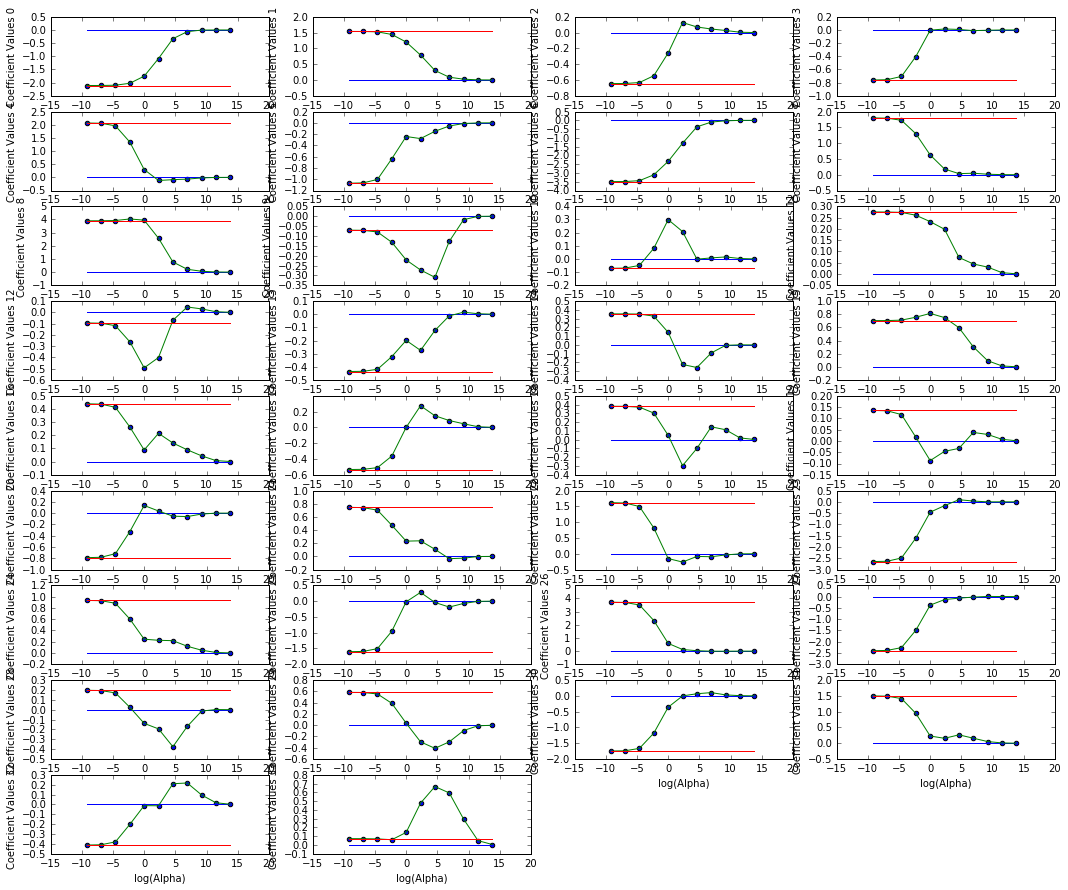

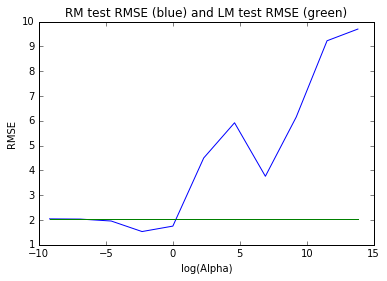

With alpha = 0.1000 we have the smallest rm test error 1.534230


In [17]:
alpha_vec = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 1e4, 1e5, 1e6]
coef_values = np.zeros(len(alpha_vec))
lm_coef_line = np.zeros(len(alpha_vec))

lm = LinearRegression()
lm.fit(X_train_scaled_d2, Y_train)
preds = lm.predict(X_dev_scaled_d2)
lm_dev_rmse = RMSE(Y_dev, preds)

fig = plt.figure(figsize=(18,15))
rm_dev_rmse_vec = []
lm_dev_rmse_vec = []
nn = len(lm.coef_)
nn_count = 0

for coef_idx in range(nn):
    nn_count += 1
    for aa_idx, aa in enumerate(alpha_vec):
        rm = Ridge(alpha=aa)
        rm.fit(X_train_scaled_d2, Y_train)
        rm_coef = rm.coef_[coef_idx]
        lm_coef = lm.coef_[coef_idx]
    
        coef_values[aa_idx] = rm_coef
        lm_coef_line[aa_idx] = lm_coef
    
        if coef_idx == 0:
            preds = rm.predict(X_dev_scaled_d2)
            rm_dev_rmse = RMSE(Y_dev, preds)
            rm_dev_rmse_vec.append(rm_dev_rmse)
            lm_dev_rmse_vec.append(lm_dev_rmse)
        
    ax = fig.add_subplot(int(nn/4)+1, 4, nn_count)    
    ax.plot(np.log(alpha_vec), lm_coef_line * 0)    
    ax.plot(np.log(alpha_vec), coef_values)
    ax.plot(np.log(alpha_vec), lm_coef_line)
    ax.scatter(np.log(alpha_vec), coef_values)
    ax.set_ylabel('Coefficient Values '+str(nn_count-1))
    ax.set_xlabel('log(Alpha)') 
plt.show()

plt.plot(np.log(alpha_vec), rm_dev_rmse_vec)
plt.plot(np.log(alpha_vec), lm_dev_rmse_vec)
plt.title('RM test RMSE (blue) and LM test RMSE (green)')
plt.xlabel('log(Alpha)')
plt.ylabel('RMSE')
plt.show()

rm_best_alpha = alpha_vec[int(np.argmin(rm_dev_rmse_vec))]
print("With alpha = %.4f we have the smallest rm test error %f" %(rm_best_alpha, min(rm_dev_rmse_vec)))

In [6]:
rm = Ridge(alpha = rm_best_alpha)
rm.fit(X_train_scaled_d2, Y_train)
rm_coefs = rm.coef_
print(rm_coefs)

[ -2.37091803e+00   1.89877060e+00  -1.01810292e+00  -6.54869376e-02
   1.42707526e-01  -7.23121067e-02  -2.76933643e+00   1.81322281e-01
   4.60087170e+00   2.44858533e-01  -1.33242565e-01   3.24327740e-01
  -2.66004955e-01   1.68957030e-01  -4.86233179e-02   7.92854965e-01
  -1.35776346e-01   5.59853572e-05   1.52014669e-01]


### L1 regularization
Lasso is the sklearn implementation of Linear Regression with L1-regularization.

In [18]:
lm = LinearRegression()
lm.fit(X_train_scaled_d2, Y_train)
preds = lm.predict(X_dev_scaled_d2)
lm_dev_rmse = RMSE(Y_dev, preds)

las = Lasso(alpha=10)
las.fit(X_train_scaled_d2, Y_train)
preds = las.predict(X_dev_scaled_d2)
las_dev_rmse = RMSE(Y_dev, preds)

print("Linear model test RMSE:     ", lm_dev_rmse)
print("Lasso regression test RMSE: ", las_dev_rmse)
print("Linear regression does worse on the test set: ", lm_dev_rmse > las_dev_rmse)

Linear model test RMSE:      2.04605696028
Lasso regression test RMSE:  7.22578842625
Linear regression does worse on the test set:  False


Now, let's see what happens to the coefficients as alpha changes. Here's an investigation for a single coefficient. What happens to other coefficients? How is this reducing complexity? You can also try out making a *regularization path plot*.

/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


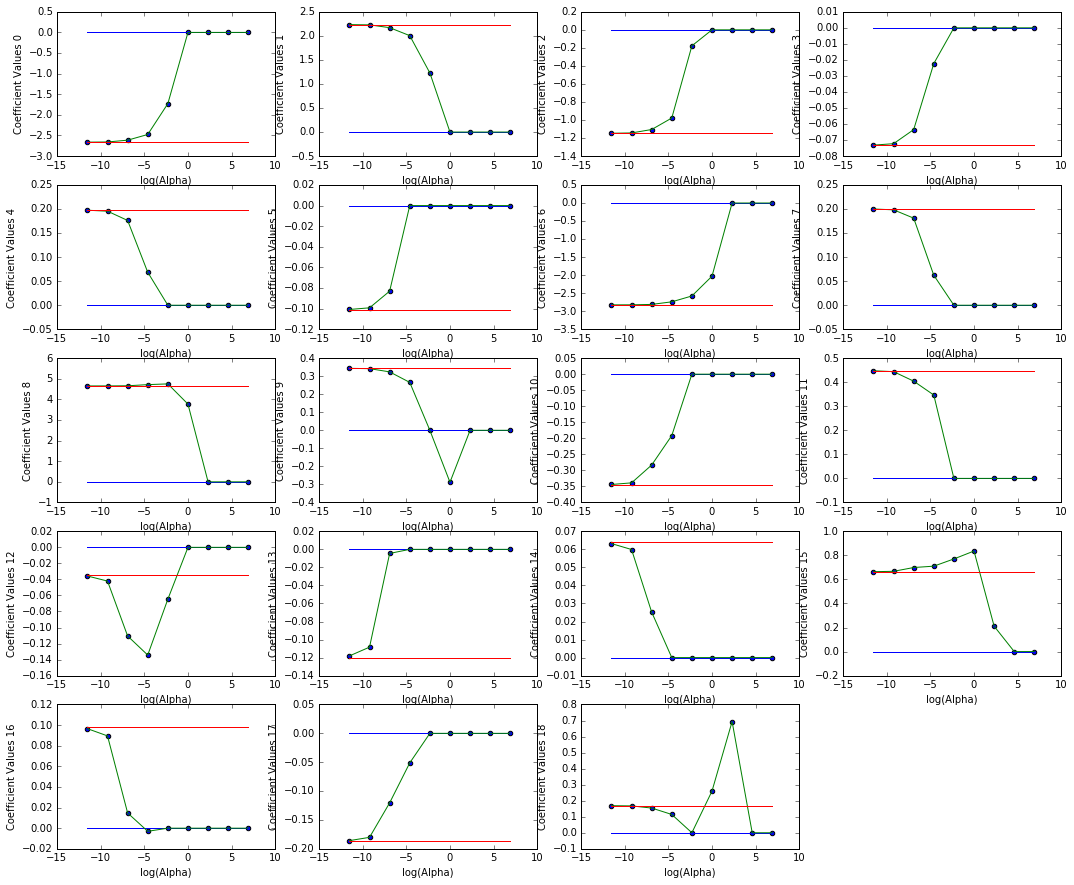

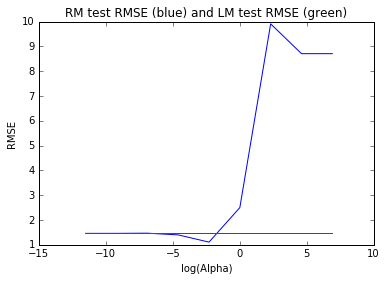

With alpha = 0.1000 we have the smallest rm test error 1.108188


In [8]:
alpha_vec = [1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 10, 100, 1e3]
coef_idx = 1
coef_values = np.zeros(len(alpha_vec))
lm_coef_line = np.zeros(len(alpha_vec))

lm = LinearRegression()
lm.fit(X_train_scaled_d2, Y_train)
preds = lm.predict(X_dev_scaled_d2)
lm_dev_rmse = RMSE(Y_dev, preds)

fig = plt.figure(figsize=(18,15))
las_dev_rmse_vec = []
lm_dev_rmse_vec = []
nn = len(lm.coef_)
nn_count = 0

for coef_idx in range(nn):
    nn_count += 1
    for aa_idx, aa in enumerate(alpha_vec):
        las = Lasso(alpha=aa)
        las.fit(X_train_scaled_d2, Y_train)
        las_coef = las.coef_[coef_idx]
        lm_coef = lm.coef_[coef_idx]
    
        coef_values[aa_idx] = las_coef
        lm_coef_line[aa_idx] = lm_coef
    
        if coef_idx == 0:
            preds = las.predict(X_dev_scaled_d2)
            las_dev_rmse = RMSE(Y_dev, preds)
            las_dev_rmse_vec.append(las_dev_rmse)
            lm_dev_rmse_vec.append(lm_dev_rmse)
        
    ax = fig.add_subplot(int(nn/4)+1, 4, nn_count)    
    ax.plot(np.log(alpha_vec), lm_coef_line * 0)    
    ax.plot(np.log(alpha_vec), coef_values)
    ax.plot(np.log(alpha_vec), lm_coef_line)
    ax.scatter(np.log(alpha_vec), coef_values)
    ax.set_ylabel('Coefficient Values '+str(nn_count-1))
    ax.set_xlabel('log(Alpha)') 
plt.show()

plt.plot(np.log(alpha_vec), las_dev_rmse_vec)
plt.plot(np.log(alpha_vec), lm_dev_rmse_vec)
plt.title('RM test RMSE (blue) and LM test RMSE (green)')
plt.xlabel('log(Alpha)')
plt.ylabel('RMSE')
plt.show()

las_best_alpha = alpha_vec[int(np.argmin(las_dev_rmse_vec))]
print("With alpha = %.4f we have the smallest rm test error %f" %(las_best_alpha, min(las_dev_rmse_vec)))

In [9]:
las = Lasso(alpha = las_best_alpha)
las.fit(X_train_scaled_d2, Y_train)
las_coefs = las.coef_
print("The coefficients are: \n", las_coefs)
print("\nUnimportant features:")
for coef in np.where(las_coefs == 0)[0]:
    print(poly.get_feature_names()[coef])

print("\nImportant features:")
for coef in np.where(las_coefs != 0)[0]:
    print(poly.get_feature_names()[coef])

The coefficients are: 
 [-1.72760929  1.22901896 -0.17750237 -0.         -0.          0.
 -2.57675541  0.          4.7512333   0.          0.          0.
 -0.06465333 -0.         -0.          0.77028283 -0.          0.          0.        ]

Unimportant features:
x0^2
x0 x1
x0 x2
x1 x2
x0^3
x0^2 x1
x0^2 x2
x0 x1 x2
x0 x2^2
x1^2 x2
x1 x2^2
x2^3

Important features:
x0
x1
x2
x1^2
x2^2
x0 x1^2
x1^3


We apply our final model to the test set and calculate the test error.

In [10]:
las = Lasso(alpha = las_best_alpha)
las.fit(np.concatenate((X_train_scaled_d2, X_dev_scaled_d2), axis=0), np.concatenate((Y_train, Y_dev), axis = 0))
preds = las.predict(X_test_scaled_d2)
error = RMSE(Y_test, preds)
print("Test error: ", error)

Test error:  1.07729073459
